In [1]:
## Finding soln to coupled eq.s
from scipy.integrate import solve_ivp
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import hyp2f1

In [2]:
# Define Ea^2 = H/H0 a^2 (to avoid singularity)
def Easquared(x,cosmo1):
    Omega_c , Omega_b , Omega_k , Omega_r , alpha_C = cosmo1
    Omega_m = Omega_c + Omega_b
    Omega_lambda = 1 - Omega_m - Omega_r - Omega_k - alpha_C
    
    return np.sqrt(Omega_m*np.exp(x) + (Omega_r + alpha_C) + Omega_k*np.exp(2*x) + Omega_lambda*np.exp(4*x))

def phi_funct_lowk(a,k,cosmo):
    y = a*(cosmo[0]+cosmo[1])/(cosmo[-1]+cosmo[-2])
    kappa = cosmo[-1]/(2*(cosmo[-2]+cosmo[-1]))
    return -(3-4*kappa)*((y/(y+1))**(4*kappa) * y**(3-4*kappa)*((12*kappa+1)*np.sqrt(1+y) * hyp2f1(0.5-4*kappa,3-4*kappa,4-4*kappa,-y) +(4*kappa-3)*(y+1)**(4*kappa))/\
           ((4*kappa-3)*(8*kappa-1)*np.sqrt(y+1)))*np.sqrt(1+y)/(y**3 * 2)

def phi_dot(x, k, params, cosmo):
    Omega_c , Omega_b , Omega_k , Omega_r , alpha_C = cosmo
    delta, phi, theta_r0, theta_r1, v = params
    Omega_m = Omega_c + Omega_b
    
    return (np.exp(x)*Omega_m*delta + 4*Omega_r*theta_r0)/(2*Easquared(x, cosmo)**2) \
           - k**2 *phi*np.exp(2*x)/(3*Easquared(x, cosmo)**2) - phi + 6*alpha_C*phi*np.exp(-2*x)/(k**2)

def theta_r0_dot(x, k, params, cosmo):
    delta, phi, theta_r0, theta_r1, v = params
    return - np.exp(x)*k*theta_r1/Easquared(x, cosmo) - phi_dot(x, k, params, cosmo)

def theta_r1_dot(x, k, params, cosmo):
    delta, phi, theta_r0, theta_r1, v = params
    return np.exp(x)*k*(theta_r0 - phi)/(3*Easquared(x, cosmo))

def delta_dot(x, k, params, cosmo):
    delta, phi, theta_r0, theta_r1, v = params
    return -3*phi_dot(x, k, params, cosmo) + np.exp(x)*k**2 * v/Easquared(x, cosmo)

def v_dot(x, k, params, cosmo):
    delta, phi, theta_r0, theta_r1, v = params
    return -v +np.exp(x)*phi/Easquared(x, cosmo)

def solution_coupled(x,params, cosmo, k):
    return [delta_dot(x, k, params, cosmo),\
           phi_dot(x, k, params, cosmo),\
           theta_r0_dot(x, k, params, cosmo),\
           theta_r1_dot(x, k, params, cosmo),
           v_dot(x, k, params, cosmo)]
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx


/tmp/ipykernel_47687/460530744.py:21: RuntimeWarning: overflow encountered in double_scalars
  - k**2 *phi*np.exp(2*x)/(3*Easquared(x, cosmo)**2) - phi + 6*alpha_C*phi*np.exp(-2*x)/(k**2)
/tmp/ipykernel_47687/460530744.py:20: RuntimeWarning: invalid value encountered in double_scalars
  return (np.exp(x)*Omega_m*delta + 4*Omega_r*theta_r0)/(2*Easquared(x, cosmo)**2) \


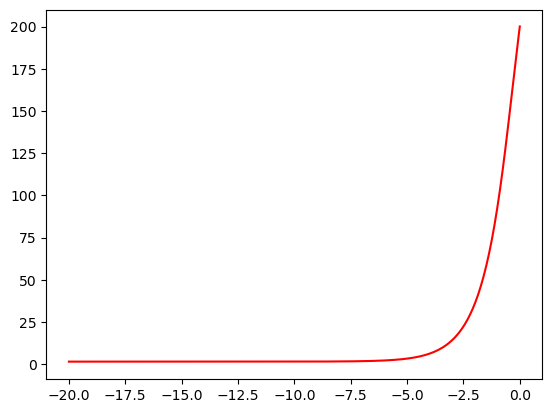

In [3]:
k = 12
x_0 = -20
x_1 = -20
Omg_rad = (1 + (7/8) * (4/11)**(4/3)*3.046)*9.227e-5
cosmo = [0.264 , 0.0493 , 0 , Omg_rad, 0]

funct = lambda z,y: solution_coupled(z,y, cosmo, k)
soln = solve_ivp(funct,(x_0,0), np.array([3/2,1,1/2,-k*np.exp(x_0)/(6*Easquared(x_0, cosmo)), np.exp(x_0)/(2*Easquared(x_0, cosmo))]), \
                 t_eval=np.linspace(x_0, 0, 500), method ='LSODA', rtol =1e-4)

plt.plot(soln.t,soln.y[0], color="r")

cosmo = [0.264 , 0.0493 , 0 , Omg_rad, 1e-5]

funct1 = lambda z,y: solution_coupled(z,y, cosmo, k)
#soln1 = solve_ivp(funct1,(x_0,0), np.array([3*(1-2*cosmo[-1]/(cosmo[-2]+cosmo[-1]))/2,1,(1-2*cosmo[-1]/(cosmo[-2]+cosmo[-1]))/2,-k*np.exp(x_0)*(1+2*cosmo[-1]/(cosmo[-2]+cosmo[-1]))/(6*Easquared(x_0, cosmo)), np.exp(x_0)*(1+2*cosmo[-1]/(cosmo[-2]+cosmo[-1]))/(2*Easquared(x_0, cosmo))]),\
#                  t_eval=np.linspace(x_0, 0, 500), method ='LSODA', rtol =1e-4)
soln1 = solve_ivp(funct1,(x_0,0), np.array([1,1e-2,1,0,0]),\
                  t_eval=np.linspace(x_0, 0, 500), method ='LSODA', rtol =1e-4)
#soln1 = solve_ivp(funct1,(x_1,0), np.array([soln.y[0][find_nearest(soln.t,x_1)],soln.y[1][find_nearest(soln.t,x_1)],soln.y[2][find_nearest(soln.t,x_1)],soln.y[3][find_nearest(soln.t,x_1)],soln.y[4][find_nearest(soln.t,x_1)]]),\
#                  t_eval=np.linspace(x_1, 0, 1000), method ='LSODA', rtol =1e-14)

plt.plot(soln1.t,soln1.y[0], color="b")

#plt.xlim(1e-10,1)
#plt.ylim(0,2)


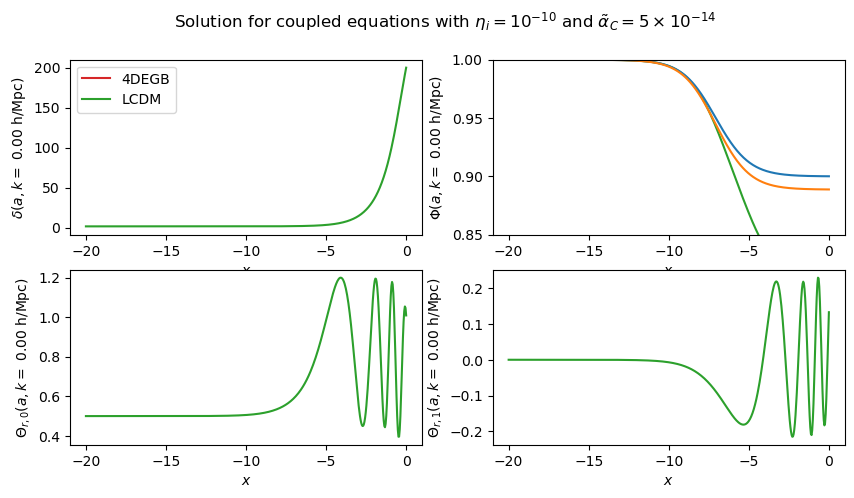

In [4]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10,5))
fig.suptitle(r'Solution for coupled equations with $\eta_i = 10^{-10}$ and $\tilde{\alpha}_C = 5 \times 10^{-14}$')

ax1.plot(soln1.t,soln1.y[0], 'tab:red', label = "4DEGB")
ax1.set_ylabel(r"$\delta(a, k= $ %.2f h/Mpc)" % float(k/3e3))
ax1.set_xlabel(r"$x$")

ax2.plot(soln1.t,soln1.y[1], 'tab:red')
ax2.set_ylabel(r"$\Phi(a, k= $ %.2f h/Mpc)" % float(k/3e3))
ax2.set_xlabel(r"$x$")

ax3.plot(soln1.t,soln1.y[2], 'tab:red')
ax3.set_ylabel(r"$\Theta_{r,0}(a, k= $ %.2f h/Mpc)" % float(k/3e3))
ax3.set_xlabel(r"$x$")

ax4.plot(soln1.t,soln1.y[3], 'tab:red')
ax4.set_ylabel(r"$\Theta_{r,1}(a, k= $ %.2f h/Mpc)" % float(k/3e3))
ax4.set_xlabel(r"$x$")

ax1.plot(soln.t,soln.y[0], 'tab:green', label = "LCDM")
ax2.plot(soln.t,soln.y[1], 'tab:green')
ax3.plot(soln.t,soln.y[2], 'tab:green')
ax4.plot(soln.t,soln.y[3], 'tab:green')

cosmo = [0.264 , 0.0493 , 0 , Omg_rad, 0]
ax2.plot(soln.t, phi_funct_lowk(np.exp(soln.t),k,cosmo))
cosmo = [0.264 , 0.0493 , 0 , Omg_rad, 3e-6]
ax2.plot(soln.t, phi_funct_lowk(np.exp(soln.t),k,cosmo))

#ax1.set_xscale("log")
#ax1.set_ylim(-6,100)
#ax1.set_xlim(-7,-4)
#ax2.set_xscale("log")
#ax2.set_xlim(-7,-4)
ax2.set_ylim(0.85,1)
#ax3.set_xscale("log")
#ax3.set_xlim(-7.1,-6.9)
#ax3.set_ylim(-3.5,3.5)
#ax4.set_xscale("log")
#ax4.set_xlim(-7.1,-6.9)

ax1.legend()
#plt.savefig("numerical_soln_coupled1")

In [33]:
plt.plot(soln5_t,soln5_y1, color="b",alpha=1, label = r"numerical 4DEGB, $a(\eta_i) = 6\times 10^{-8}$")

plt.plot(soln1.t,soln1.y[1], color="b",alpha=0.7, label = r"numerical 4DEGB, $a(\eta_i) = 7\times 10^{-8}$")

plt.plot(soln2_t,soln2_y1, color="b",alpha=0.4, label = r"numerical 4DEGB, $a(\eta_i) = 10^{-7}$")
plt.plot(soln4_t,soln4_y1, color="b",alpha=0.3, label = r"numerical 4DEGB, $a(\eta_i) = 2\times 10^{-7}$")
plt.plot(soln3_t,soln3_y1, color="b",alpha=0.2, label = r"numerical 4DEGB, $a(\eta_i) = 3\times 10^{-7}$")
plt.plot(soln.t,soln.y[1], color="r", label = "LCDM")
#plt.plot(soln.t, phi_funct(soln.t,k,[0.264 , 0.0493 , 0 , Omg_rad, 0]))
plt.plot(soln1.t, phi_funct_lowk(soln1.t,k,[0.264 , 0.0493 , 0 , Omg_rad, 1e-6]), color="g", label = r"analytical 4DEGB")
#plt.plot(soln.t, phi_funct_highk(soln.t,k,[0.264 , 0.0493 , 0 , Omg_rad, 1e-5]))
#plt.plot(soln1.t, phi_funct_highk(soln1.t,k,cosmo))
plt.xscale("log")
plt.ylim(-0.5,4)
plt.xlim(1e-7,1e-4)
plt.text(2e-7,3.5,r"$\tilde{\alpha}_C = 10^{-6}$", fontsize =15)
plt.ylabel(r"$\Phi(a, k= $ %.2f h/Mpc)" % float(k/3e3))
plt.xlabel(r"$a$")

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.rcParams["figure.autolayout"] = True
plt.rcParams["figure.figsize"] = (10,4)
#plt.savefig("numerical_soln_analytical")

NameError: name 'soln5_t' is not defined